# LangGraph and LangSmith - Agentic RAG Powered by LangChain

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!

  - 🤝 Breakout Room #2:
  1. Evaluating the LangGraph Application with LangSmith
  2. Adding Helpfulness Check and "Loop" Limits
  3. LangGraph for the "Patterns" of GenAI

# 🤝 Breakout Room #1

## Part 1: LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

### Why LangGraph?

Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

## Task 1:  Dependencies

We'll first install all our required libraries.

In [1]:
# Changed this to freeze the versions after learning lesson yesterday
!pip install -qU langgraph==0.2.14 langchain==0.2.14 langchain_openai==0.1.23 langchain_core==0.2.35 langchain-community==0.2.12 arxiv duckduckgo_search==5.3.1b1

## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [2]:
import os
# import getpass

# os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [3]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE4 - LangGraph - {uuid4().hex[0:8]}"
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Duck Duck Go Web Search](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/ddg_search)
- [Arxiv](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/arxiv)

#### 🏗️ Activity #1:

Please add the tools to use into our toolbelt.  
> NOTE: Each tool in our toolbelt should be a method.
---
## METHODS ARE ADDED AS LIST OF FUNCTIONS BELOW.
---

In [4]:
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
from langchain_community.tools.arxiv.tool import ArxivQueryRun

tool_belt = [
    DuckDuckGoSearchRun(), 
    ArxivQueryRun()
]

### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - but it's not *necessary* to use with LangGraph. LangGraph supports all models - though you might not find success with smaller models - as such, they recommend you stick with:

- OpenAI's GPT-3.5 and GPT-4
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [5]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [6]:
model = model.bind_tools(tool_belt)

#### ❓ Question #1:

How does the model determine which tool to use?

---

### ANSWER #1:

Given a user query, the model decides if it already has enough information to answer without doing anything.  If the model decides that it does not have sufficient information, then it will decide which tool to use based on its understanding of the query.  So if the query includes Arxiv then the LLM will almost certainly select ArxivQueryRun().  The model decision is potentially impacted by information in the tools themselves.  

The ArxivQueryRun() method has the following description:
```    
     description: str = (
        "A wrapper around Arxiv.org "
        "Useful for when you need to answer questions about Physics, Mathematics, "
        "Computer Science, Quantitative Biology, Quantitative Finance, Statistics, "
        "Electrical Engineering, and Economics "
        "from scientific articles on arxiv.org. "
        "Input should be a search query."
    )
```
The DuckDuckGoSearchRun() method has the following description:
 ```
     description: str = (
        "A wrapper around DuckDuckGo Search. "
        "Useful for when you need to answer questions about current events. "
        "Input should be a search query."
    )
```
If the query contains information that could lead to either function, such as "current events reported in Arxiv", then the selection may vary.  If we configure our tools using ToolNode (as we will), then multiple simultaneous calls may be made if determined to be relevant to the query.  This is the situation with the QLoRA author tweets situation later in this notebook.

---

## Task 4: Putting the State in Stateful

Earlier we used this phrasing:

`coordinated multi-actor and stateful applications`

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. We initialize our state object:
  - `{"messages" : []}`
2. Our user submits a query to our application.
  - New State: `HumanMessage(#1)`
  - `{"messages" : [HumanMessage(#1)}`
3. We pass our state object to an Agent node which is able to read the current state. It will use the last `HumanMessage` as input. It gets some kind of output which it will add to the state.
  - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
  - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass our state object to a "conditional node" (more on this later) which reads the last state to determine if we need to use a tool - which it can determine properly because of our provided object!

In [7]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages

##  It is unclear to me (Mike Dean) why we need to import operator and BaseMessage
##  So I will play with fire and comment them out.
# import operator
# from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

## Task 5: It's Graphing Time!

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".

Let's create some nodes and expand on our diagram.

> NOTE: Due to the tight integration with LCEL - we can comfortably create our nodes in an async fashion!

In [8]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  # print("Inside call-model node:\n")
  # print("messages:\n")
  # print(messages) 
  # print("\nresponse:\n")
  # print(response)
  # print("\n")
  return {"messages" : [response]}

tool_node = ToolNode(tool_belt)

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `tool_node` is a node which can call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [9]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

Let's look at what we have so far:

![image](https://i.imgur.com/md7inqG.png)

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [10]:
uncompiled_graph.set_entry_point("agent")

![image](https://i.imgur.com/wNixpJe.png)

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [11]:
def should_continue(state):
  last_message = state["messages"][-1]
  # print("Inside should_continue node: \n")
  # print("Last message:\n")
  # print(last_message)
  # print("\n")
  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)
# I explored changing this code but then the action is not reachable.
# uncompiled_graph.add_edge("agent", should_continue)

Let's visualize what this looks like.

![image](https://i.imgur.com/8ZNwKI5.png)

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [12]:
uncompiled_graph.add_edge("action", "agent")

Let's look at the final visualization.

![image](https://i.imgur.com/NWO7usO.png)

All that's left to do now is to compile our workflow - and we're off!

In [13]:
compiled_graph = uncompiled_graph.compile()

#### ❓ Question #2:

Is there any specific limit to how many times we can cycle?

If not, how could we impose a limit to the number of cycles?

---
#### ANSWER #2:
There is no specific limit to how many times we can cycle, unless theoretically we run out of memory to hold the state object.  (This would have been a problem when we only had 16K of memory!)  We are dependent on the agent node at some point to send a message that does not contain a tool call (i.e. last_message.tool_calls is empty).  This is of course an LLM decision.

We could create an invalid graph structure but I presume that the graph compile() is smart enough to catch that.

The main way to impose a limit to the number of cycles is to set a specific limit (count the number of iterations and compare to a limit or count the number of state changes and impose a limit).  Another approach is to use a time-based exit, but given the speed of our computers and the LLMs, this would be financially dangerous.  

---

## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:

In [14]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="Who is the current captain of the Winnipeg Jets?")]}
# print(f"Inputs into the chain: {inputs}\n")
async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9yrwMV2D10dI6E9xXZ3fFyoe', 'function': {'arguments': '{"query":"current captain of the Winnipeg Jets 2023"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 156, 'total_tokens': 181}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_fde2829a40', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0a8dbf52-5b98-4e43-b235-fa76be0b377c-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'current captain of the Winnipeg Jets 2023'}, 'id': 'call_9yrwMV2D10dI6E9xXZ3fFyoe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 156, 'output_tokens': 25, 'total_tokens': 181})]



Receiving update from node: 'action'
[ToolMessage(content='The Winnipeg Jets will have a captain for the 2023-24 season. After going captain-less in 2022-23, the Winnipeg Jets unveiled 

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "tool_calls" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "tool_calls" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [15]:
inputs = {"messages" : [HumanMessage(content="Search Arxiv for the QLoRA paper, then search each of the authors to find out their latest Tweet using DuckDuckGo.")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])

        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4rC8Y1tevjbsJyvX79fAhYr5', 'function': {'arguments': '{"query": "QLoRA"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_xQqq9kcyvit6sp8Jesbd7vue', 'function': {'arguments': '{"query": "QLoRA paper authors"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 173, 'total_tokens': 226}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-18bd629c-7b78-4a73-b79b-63f6109b319a-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'QLoRA'}, 'id': 'call_4rC8Y1tevjbsJyvX79fAhYr5', 'type': 'tool_call'}, {'name': 'duckduckgo_search', 'args': {'query': 'QLoRA paper authors'}, 'id': 'call_xQqq9kcyvit6sp8Jesbd7vue', 'type': 'tool_call'}], usage_metadata={'input_tokens': 173, 'output_tokens': 53, 'total_tokens': 226}

#### 🏗️ Activity #2:

Please write out the steps the agent took to arrive at the correct answer.

---
#### Activity 2
1. The agent received the query.  It then set up parallel calls to the two functions.  It called arxiv with a query "QLoRA" and it called duckduckgo_search with query "latest tweet".  This behavior is availble because we used ToolNode to configure the tool binding to the model.
2. The action node executed the arxiv action and returned the paper information.  It ALSO executed the duckduckgo_search and retrieved a bunch of tweets that are absolutely unrelated to our query.
3. The agent then set up four calls to duckduckgo_search, one for each of the authors.
4. The action node returned an unrelated tweet, presumably because of the original call in step one, but then returned four specific answers for each of the authors.
5. The agent provided the final answer, which is shown in the code cell below.

---

In [16]:
print(values['messages'][-1].content)

Here are the latest updates and tweets from the authors of the QLoRA paper:

### Tim Dettmers
- **Latest Update**: Tim Dettmers is joining Ai2 as an AI researcher. He specializes in efficient deep learning at the intersection of machine learning, NLP, and more.
- **Latest Tweet**: No specific tweet found, but he has been involved in discussions about efficient deep learning and quantization techniques.

### Artidoro Pagnoni
- **Latest Update**: Error encountered while searching for the latest tweet. Please try again later.

### Ari Holtzman
- **Latest Update**: Ari Holtzman is an incoming professor at the University of Chicago. He has been involved in various discussions and interviews, including a heated on-air dispute on MSNBC.
- **Latest Tweet**: No specific tweet found, but he has been active in discussions about his research and academic contributions.

### Luke Zettlemoyer
- **Latest Update**: Luke Zettlemoyer is a research manager and site lead for FAIR Seattle, and a Professor 

---

## Part 1: LangSmith Evaluator

### Pre-processing for LangSmith

To do a little bit more preprocessing, let's wrap our LangGraph agent in a simple chain.

In [17]:
def convert_inputs(input_object):
  return {"messages" : [HumanMessage(content=input_object["question"])]}

def parse_output(input_state):
  return input_state["messages"][-1].content

agent_chain = convert_inputs | compiled_graph | parse_output

In [18]:
import pprint
pprint.pprint(agent_chain.invoke({"question" : "What is RAG?"}))

('RAG stands for Retrieval-Augmented Generation. It is a technique used in '
 'natural language processing (NLP) and machine learning to improve the '
 'performance of language models by combining retrieval-based methods with '
 "generative models. Here's a brief overview of how it works:\n"
 '\n'
 '1. **Retrieval**: In the first step, the system retrieves relevant documents '
 'or pieces of information from a large corpus or database. This is typically '
 'done using a retrieval model, such as BM25 or a dense retrieval model like '
 'DPR (Dense Passage Retrieval).\n'
 '\n'
 '2. **Augmentation**: The retrieved documents are then used to augment the '
 'input to the generative model. This means that the generative model has '
 'access to additional context or information that can help it produce more '
 'accurate and relevant responses.\n'
 '\n'
 '3. **Generation**: Finally, the generative model, such as GPT-3 or BERT, '
 'uses the augmented input to generate a response. The additional 

### Task 1: Creating An Evaluation Dataset

Just as we saw last week, we'll want to create a dataset to test our Agent's ability to answer questions.

In order to do this - we'll want to provide some questions and some answers. Let's look at how we can create such a dataset below.

```python
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]
```

####🏗️ Activity #3:

Please create a dataset in the above format with at least 5 questions.

---

I copied the above questions and answers, and used those for the three initial experiments that are discussed later in the notebook.  Then I added some more here.

---

In [40]:
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?",
    "Who authored the original QLoRA paper?",
    "What was the name of the best model family used in the original QLoRA paper?",
    "What distinguishes QLoRA from vanilla LoRA?",
    "What data type has the best performance with QLoRA, FP4 or NF4?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
    {"must_mention" : ["Dettmers"]},
    {"must_mention" : ["Guanaco"]},
    {"must_mention" : ["quantization"]},
    {"must_mention" : ["NF4"]},

]

Now we can add our dataset to our LangSmith project using the following code which we saw last Thursday!

In [41]:
from langsmith import Client

client = Client()
dataset_name = f"Retrieval Augmented Generation - Mike's Evaluation Dataset - {uuid4().hex[0:8]}"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the QLoRA Paper to Evaluate RAG over the same paper."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    outputs=answers,
    dataset_id=dataset.id,
)

In [21]:
print(answers)

[{'must_mention': ['paged', 'optimizer']}, {'must_mention': ['NF4', 'NormalFloat']}, {'must_mention': ['ground', 'context']}, {'must_mention': ['Tim', 'Dettmers']}, {'must_mention': ['PyTorch', 'TensorFlow']}, {'must_mention': ['reduce', 'parameters']}]


In [22]:
print([{"question" : q} for q in questions])

[{'question': 'What optimizer is used in QLoRA?'}, {'question': 'What data type was created in the QLoRA paper?'}, {'question': 'What is a Retrieval Augmented Generation system?'}, {'question': 'Who authored the QLoRA paper?'}, {'question': 'What is the most popular deep learning framework?'}, {'question': 'What significant improvements does the LoRA system make?'}]


#### ❓ Question #3:

How are the correct answers associated with the questions?

> NOTE: Feel free to indicate if this is problematic or not

---

### ANSWER 3:
The way this was set up, the answers are associated with questions by the order in which they were defined in the two lists, i.e. by position in the list.
This is clearly problematic because it would be easy to get one of the lists out of order and this would corrupt the entire dataset.  A better way to do this would be to create 
a list of tuples containing a question and its specific answers:

```
eval_data = [
    ("What optimizer is used in QLoRA?", {"must_mention" : ["paged", "optimizer"]}),
    ("What data type was created in the QLoRA paper?",{"must_mention" : ["NF4", "NormalFloat"]}),
    ("What is a Retrieval Augmented Generation system?",{"must_mention" : ["ground", "context"]}),
    ("Who authored the QLoRA paper?",{"must_mention" : ["Tim", "Dettmers"]}),
    ("What is the most popular deep learning framework?",{"must_mention" : ["PyTorch", "TensorFlow"]}),
    ("What significant improvements does the LoRA system make?", {"must_mention" : ["reduce", "parameters"]}),
]
```


---

### Task 2: Adding Evaluators

Now we can add a custom evaluator to see if our responses contain the expected information.

We'll be using a fairly naive exact-match process to determine if our response contains specific strings.

In [42]:
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    return EvaluationResult(key="must_mention", score=score)

#### ❓ Question #4:

What are some ways you could improve this metric as-is?

> NOTE: Alternatively you can suggest where gaps exist in this method.

---

### ANSWER #4:

Not sure what is meant by improving this metric "as-is" but I presume this means to leave the must_mention function as written.  If this is correct assumption, then improving this metric is dependent on being more careful with the question/answer data.  For example, using pairs of words in the must_mention lists forces BOTH words to be found.  This could be fine in some situations where we want a phrase, but if that is the intention then the phrase could be a single string.  One example of a bad question is asking for THE most popular framework but expecting TWO answers (which turns out ok by luck because the papers say two of the most popular ...).  

The questions must be precise.  For example, asking about who authored the QLoRA paper is a vague question, and in several of the experiments that I ran, a different paper was pulled instead of the "original" paper authored by Dettmers.  

If "as-is" does not mean to freeze the must_mention() method above, then we could add some fuzziness in this method that would handle capitalization, different forms of the same word, etc.  For example, Nf4 and NormalFload would not pass the test about the data type.  I know that the paper mentions NF4 but the author of the example might mispell it as well.  But the significant improvement is"parameter reduction", but the required answer has to include "reduce parameters",  which will fail our exact match approach.

I ran the evaluation later in this notebook three times USING THE ORIGINAL EXAMPLES, and the results were variable despite not changing any code nor evaluation models, as shown below.  This is largely because the metric overall (the method and the examples) have not been optimized.

![Metric Experiments](metric.png)

---

Now that we have created our custom evaluator - let's initialize our `RunEvalConfig` with it!

In [43]:
from langchain.smith import RunEvalConfig, run_on_dataset

eval_config = RunEvalConfig(
    custom_evaluators=[must_mention],
)

Task 3: Evaluating

All that is left to do is evaluate our agent's response!

In [44]:
client.run_on_dataset(
    dataset_name=dataset_name,
    llm_or_chain_factory=agent_chain,
    evaluation=eval_config,
    verbose=True,
    project_name=f"RAG Pipeline - Evaluation - {uuid4().hex[0:8]}",
    project_metadata={"version": "1.0.0"},
)

View the evaluation results for project 'RAG Pipeline - Evaluation - 258024df' at:
https://smith.langchain.com/o/b47f3abe-d937-5f35-8caa-ad9d628ed67f/datasets/a544cd8d-6cc8-4abe-93a6-e50c6cfc87c3/compare?selectedSessions=322d89e9-a2b8-45b2-81da-6e26248370c4

View all tests for Dataset Retrieval Augmented Generation - Mike's Evaluation Dataset - cc8b64db at:
https://smith.langchain.com/o/b47f3abe-d937-5f35-8caa-ad9d628ed67f/datasets/a544cd8d-6cc8-4abe-93a6-e50c6cfc87c3
[------------------------------------------------->] 10/10

,feedback.must_mention,error,execution_time,run_id
count,10,0,10.000000,10
unique,2,0,NaN,10
top,True,NaN,NaN,a2fd0bc5-61b4-41f8-a089-4fdd3494cefc
freq,5,NaN,NaN,1
mean,NaN,NaN,4.593186,NaN
std,NaN,NaN,2.158017,NaN
min,NaN,NaN,2.591233,NaN
25%,NaN,NaN,3.129456,NaN
50%,NaN,NaN,3.717148,NaN
75%,NaN,NaN,5.745308,NaN


{'project_name': 'RAG Pipeline - Evaluation - 258024df',
 'results': {'7d211e5b-a159-4dae-9db2-9e01c6c26fa9': {'input': {'question': 'What optimizer is used in QLoRA?'},
   'feedback': [EvaluationResult(key='must_mention', score=True, value=None, comment=None, correction=None, evaluator_info={}, feedback_config=None, source_run_id=UUID('25e2467e-4651-46e6-91ad-aa92b5b576b7'), target_run_id=None)],
   'execution_time': 3.698102,
   'run_id': 'a2fd0bc5-61b4-41f8-a089-4fdd3494cefc',
   'output': 'QLoRA (Quantized Low-Rank Adaptation) uses a combination of optimizers to manage memory efficiently during the fine-tuning of large language models. Specifically, it introduces "paged optimizers" to handle memory spikes. This approach allows QLoRA to backpropagate gradients through a frozen, 4-bit quantized pretrained language model into Low Rank Adapters (LoRA), significantly reducing memory usage while preserving performance.',
   'reference': {'must_mention': ['paged', 'optimizer']}},
  'b7f7b

## Part 2: LangGraph with Helpfulness:

### Task 3: Adding Helpfulness Check and "Loop" Limits

Now that we've done evaluation - let's see if we can add an extra step where we review the content we've generated to confirm if it fully answers the user's query!

We're going to make a few key adjustments to account for this:

1. We're going to add an artificial limit on how many "loops" the agent can go through - this will help us to avoid the potential situation where we never exit the loop.
2. We'll add to our existing conditional edge to obtain the behaviour we desire.

First, let's define our state again - we can check the length of the state object, so we don't need additional state for this.

In [28]:
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

Now we can set our graph up! This process will be almost entirely the same - with the inclusion of one additional node/conditional edge!

####🏗️ Activity #5:

Please write markdown for the following cells to explain what each is doing.

##### YOUR MARKDOWN HERE

In this cell we are instantiating graph_with_helpfulness_check as a StateGraph object, using AgentState as the state definition that will be tracked in the overall graph.

We are then adding our two nodes, previously defined.  After this cell is executed, we have two "floating" nodes without any edges or entry points.

In [29]:
graph_with_helpfulness_check = StateGraph(AgentState)

graph_with_helpfulness_check.add_node("agent", call_model)
graph_with_helpfulness_check.add_node("action", tool_node)

##### YOUR MARKDOWN HERE

Here we are adding our entry point to the graph, which is the agent node.

In [30]:
graph_with_helpfulness_check.set_entry_point("agent")

##### YOUR MARKDOWN HERE

This function will evaluate our current state.  Recall that our state object consists only of a list of messages, which are automatically updated at every state change.  The last message in state is the most recent state change.  If this message included a tool_calls argument, then we return from the function with "action" and that will route us to the action node.. Remember that if there is no tool_calls argument in the last message, then by definition the last message IS the FINAL response.

If we have a final response and have not exceeded our limit of ten cycles, then we set up a new prompt template that tells the LLM to judge helpfulness by comparing the original query with the final response.  The prompt template expects the initial_query and final_response as parameters.  The chain is then invoked, returning yes or no for helpfulness.

In [31]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def tool_call_or_helpful(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  initial_query = state["messages"][0]
  final_response = state["messages"][-1]

  if len(state["messages"]) > 10:
    return "END"

  prompt_template = """\
  Given an initial query and a final response, determine if the final response is extremely helpful or not. Please indicate helpfulness with a 'Y' and unhelpfulness as an 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  prompt_template = PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4")

  helpfulness_chain = prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  if "Y" in helpfulness_response:
    return "end"
  else:
    return "continue"

#### 🏗️ Activity #4:

Please write what is happening in our `tool_call_or_helpful` function!

---

We start by pulling the last message in state and checking if it included a tool_call argument, in which case we return from the function with "action".

The next two statements simply pull the original query and final result off of the state object (the first and last messages).

If we have reached ten iterations, then we return end.  This is our loop limit or check.

---

##### YOUR MARKDOWN HERE

We create a conditional edge from agent into the function we defined above, and from there the chain will be routed to one of three places, depending on what was returned from the function.  If "continue" then the chain will go to the agent, if "action" then the chain will continue to the action node, and if "end" then we will exit the chain.

In [32]:
graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    tool_call_or_helpful,
    {
        "continue" : "agent",
        "action" : "action",
        "end" : END
    }
)

##### YOUR MARKDOWN HERE

Right now our action agent has no communication route back to the agent, so we add that edge here.  Otherwise, there is now way out of the action node.

In [33]:
graph_with_helpfulness_check.add_edge("action", "agent")

##### YOUR MARKDOWN HERE

Compile our chain!  And below that, I have added a Mermaid to confirm what I think is going on.

In [34]:
agent_with_helpfulness_check = graph_with_helpfulness_check.compile()

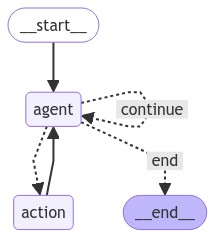

In [35]:
from IPython.display import Image, display

try:
    display(Image(agent_with_helpfulness_check.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

##### YOUR MARKDOWN HERE

Let's invoke the chain with three questions.  Then we look at what happens.  THe first state update is done by agent, which looks at each question, determines to use DuckDuckQuery for each of them, and sends to action the three required actions.  The action node has a ToolNode which allows parallel calls to return information from the web for all three questions.  WHen this is finished, then control is returned to agent, which updates the state with the final response.  NOTE that our helpfulness function presumably decided the responses were helpful but did not store Yes or No in the state - it simply routed the chain.

In [36]:
inputs = {"messages" : [HumanMessage(content="Related to machine learning, what is LoRA? Also, who is Tim Dettmers? Also, what is Attention?")]}

async for chunk in agent_with_helpfulness_check.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_L2flWgp3hNMDe8pSMp1egwlq', 'function': {'arguments': '{"query": "LoRA machine learning"}', 'name': 'duckduckgo_search'}, 'type': 'function'}, {'id': 'call_5P7rToKhc5XWDfrzxcOYkA4Q', 'function': {'arguments': '{"query": "Tim Dettmers"}', 'name': 'duckduckgo_search'}, 'type': 'function'}, {'id': 'call_jfBKBTAQVFeSpunBMhRL8JV2', 'function': {'arguments': '{"query": "Attention in machine learning"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 171, 'total_tokens': 247}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b6886d60-ba6d-4832-9d8d-efad4bd1b5e1-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'LoRA machine learning'}, 'id': 'call_L2flWgp3hNMDe8pSMp1egwlq', 'type': 'tool_call'}, 

### I'd like to read the response:

In [37]:
print(values['messages'][-1].content)

### LoRA in Machine Learning
Low-Rank Adaptation (LoRA) is a technique used in machine learning to efficiently fine-tune large pre-trained models, such as language models or vision transformers, for specific tasks. Instead of adjusting all the parameters of the model, LoRA modifies only a small, low-rank subset of the model's parameters. This approach significantly reduces the computational resources required for fine-tuning while maintaining the model's performance. LoRA is particularly useful for adapting large models to new tasks with smaller datasets.

### Tim Dettmers
Tim Dettmers is a researcher specializing in efficient deep learning, particularly at the intersection of machine learning, natural language processing (NLP), and computer systems. He is known for his work on quantization and the use of deep learning hardware accelerators. One of his notable contributions is QLoRA, a method that significantly reduces the GPU memory required to fine-tune large language models. Tim Det

### Task 4: LangGraph for the "Patterns" of GenAI

Let's ask our system about the 4 patterns of Generative AI:

1. Prompt Engineering
2. RAG
3. Fine-tuning
4. Agents

In [38]:
patterns = ["prompt engineering", "RAG", "fine-tuning", "LLM-based agents"]

#### MY ADDITIONAL MARKDOWN
We pass in a list of topics and then call our chain with the list.  I added a print statement for the last content.

In [39]:
for pattern in patterns:
  what_is_string = f"What is {pattern} and when did it break onto the scene??"
  inputs = {"messages" : [HumanMessage(content=what_is_string)]}
  messages = agent_with_helpfulness_check.invoke(inputs)
  print(messages["messages"][-1].content)
  print("\n\n")
  ## Make it readable!
  print(values['messages'][-1].content)

Prompt engineering is a concept primarily associated with the field of artificial intelligence, particularly in the context of natural language processing (NLP) and large language models like GPT-3. It involves the design and crafting of prompts (input text) to elicit desired responses from AI models. The goal is to optimize the input to get the most accurate, relevant, or useful output from the model.

### Key Aspects of Prompt Engineering:
1. **Crafting Effective Prompts**: Designing prompts that are clear, specific, and structured in a way that guides the AI to produce the desired output.
2. **Iterative Testing**: Continuously refining prompts based on the responses received to improve the quality and relevance of the output.
3. **Understanding Model Behavior**: Gaining insights into how the model interprets different types of prompts and using this knowledge to influence the responses.

### Emergence of Prompt Engineering:
Prompt engineering became more prominent with the advent of